Dataset Link: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset/data

**Importing the Dependencies**

In [ ]:
import os
import json

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

**Data Collection**

In [ ]:
# loading the dataset to a pandas dataframe
df = pd.read_csv("/content/spotify_millsongdata[1].csv", engine='python', on_bad_lines='skip', quotechar='"', escapechar='\\')

**Initial Understanding**

In [ ]:
df.shape

(57650, 4)

In [ ]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [ ]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [ ]:
# Top artists and songs
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [ ]:
df = df.sample(8000)

df = df.drop('link', axis=1).reset_index(drop=True)

In [ ]:
df.shape

(8000, 3)

In [ ]:
df.head()

,artist,song,text
0,Britney Spears,Criminal,"He is a hustler, he's no good at all \r\nHe i..."
1,Dean Martin,Carolina In The Morning,Nothing could be finer than to be in Carolina ...
2,Natalie Cole,Lush Life,I used to visit all the very gay places \r\nT...
3,Richard Marx,Keep Coming Back,You know just how to hurt me \r\nAnd how to t...
4,Demi Lovato,"So Far, So Great","Off to the races, I'm going places \r\nMight ..."


In [ ]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

WordCloud to visualize the most common words in the lyrics.

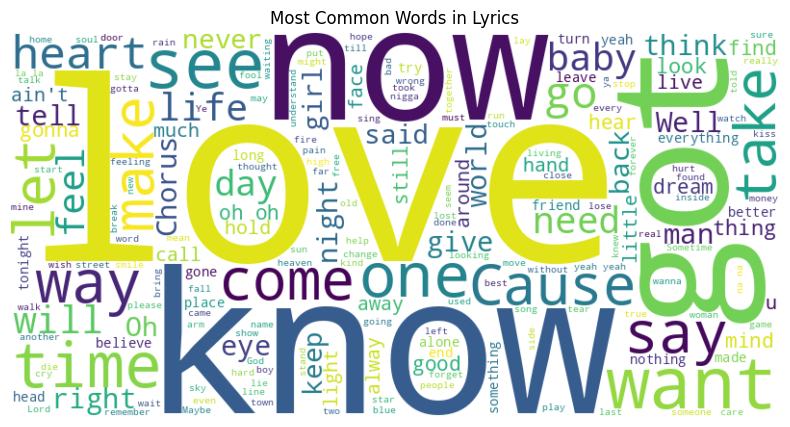

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()

**Data Preprocessing**

In [ ]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,artist,song,text,cleaned_text
0,Britney Spears,Criminal,"He is a hustler, he's no good at all \r\nHe i...",hustler hes good loser hes bum bum bum bum lie...
1,Dean Martin,Carolina In The Morning,Nothing could be finer than to be in Carolina ...,nothing could finer carolina morning one could...
2,Natalie Cole,Lush Life,I used to visit all the very gay places \r\nT...,used visit gay places come may places one rela...
3,Richard Marx,Keep Coming Back,You know just how to hurt me \r\nAnd how to t...,know hurt take pain away girl must devil disgu...
4,Demi Lovato,"So Far, So Great","Off to the races, I'm going places \r\nMight ...",races im going places might long shot gon na w...


In [ ]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [ ]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# Recommendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"   # can be reworked to compare for songs not present in the dataset
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get song indices
    song_indices = [i[0] for i in sim_scores]

    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [ ]:
df["song"][2]

'Lush Life'

In [ ]:
# Example Recommendation
song= input()
print("\nRecommendations for the song",song)
recommendations = recommend_songs(song) # df["song"][2]
print(recommendations)

my girl

Recommendations for the song my girl
                 artist                               song
135     The Temptations  Girl (Why You Wanna Make Me Blue)
3909  Pharrell Williams                     Marilyn Monroe
6393              Ne-Yo                         Girlfriend
7762     Iron Butterfly                  Flowers And Beads
6834            Journey                        Little Girl
